In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import ElementsEnv

%erun Elements 5.12.0

os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/auxdir/'

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2

from nnpz.photometry import DirectoryFilterProvider, FnuuJyPrePostProcessor, PhotometryCalculator
from nnpz.reference_sample.ReferenceSample import ReferenceSample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
ref = ReferenceSample('/home/aalvarez/Work/Data/SC8/PHZ_Prod_02jun21/ref_sample.dir/')

WARN    : Index for provider "pdz" does not follow the physical layout for file 1
2021-10-04T15:44:34CEST nnpz.reference_sample.IndexProvider  WARN : Index for provider "pdz" does not follow the physical layout for file 1
WARN    : Sorting index based on ['sed_file', 'sed_offset', 'pdz_file', 'pdz_offset']
2021-10-04T15:44:34CEST nnpz.reference_sample.IndexProvider  WARN : Sorting index based on ['sed_file', 'sed_offset', 'pdz_file', 'pdz_offset']
INFO    : Found provider PdzProvider
2021-10-04T15:44:34CEST ReferenceSample  INFO : Found provider PdzProvider
INFO    : Found provider SedProvider
2021-10-04T15:44:34CEST ReferenceSample  INFO : Found provider SedProvider


In [6]:
filters_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/SC8/PHZ_Calibration_28jan21/PhosphorosRootEcdmHandler/Phosphoros/AuxiliaryData/Filters/')

In [8]:
filter_map = {}
filter_names = filters_provider.getFilterNames()
for filter_name in filter_names:
    filter_map[filter_name] = filters_provider.getFilterTransmission(filter_name)

In [9]:
sed = ref.getSedData(8069720754360000)

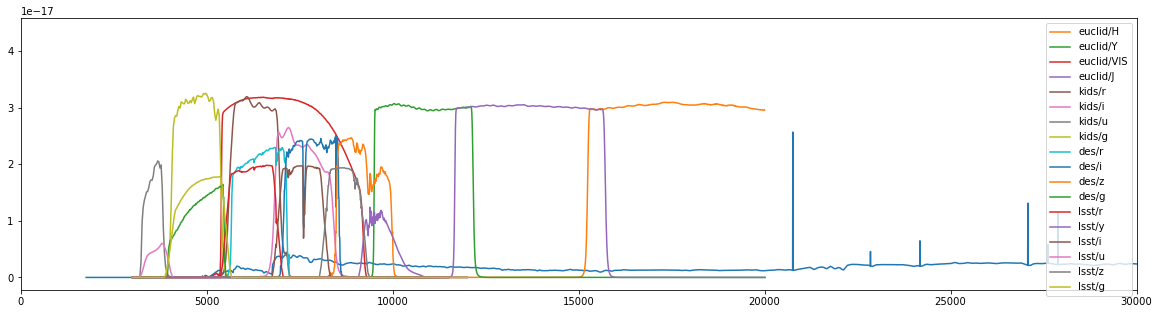

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(sed[:,0], sed[:,1])
msed = sed[:,1].max()
for fname, ftrans in filter_map.items():
    plt.plot(ftrans[:,0], ftrans[:,1]*msed, label=fname)
plt.xlim(0, 30000)
plt.legend()

In [11]:
prepost = FnuuJyPrePostProcessor(filter_map)
shifts = np.concatenate([np.arange(-100, 0), np.arange(1, 101)])
extra_shifts = np.concatenate([np.arange(-200, -100), np.arange(100, 201)])

In [18]:
calculator = PhotometryCalculator(filter_map, prepost, shifts)

In [19]:
photo, corr, raw = calculator.compute(sed, return_raw=True)

In [20]:
extrapolate = PhotometryCalculator(filter_map, prepost, extra_shifts)
_, _, raw_extra = extrapolate.compute(sed, return_raw=True)

/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


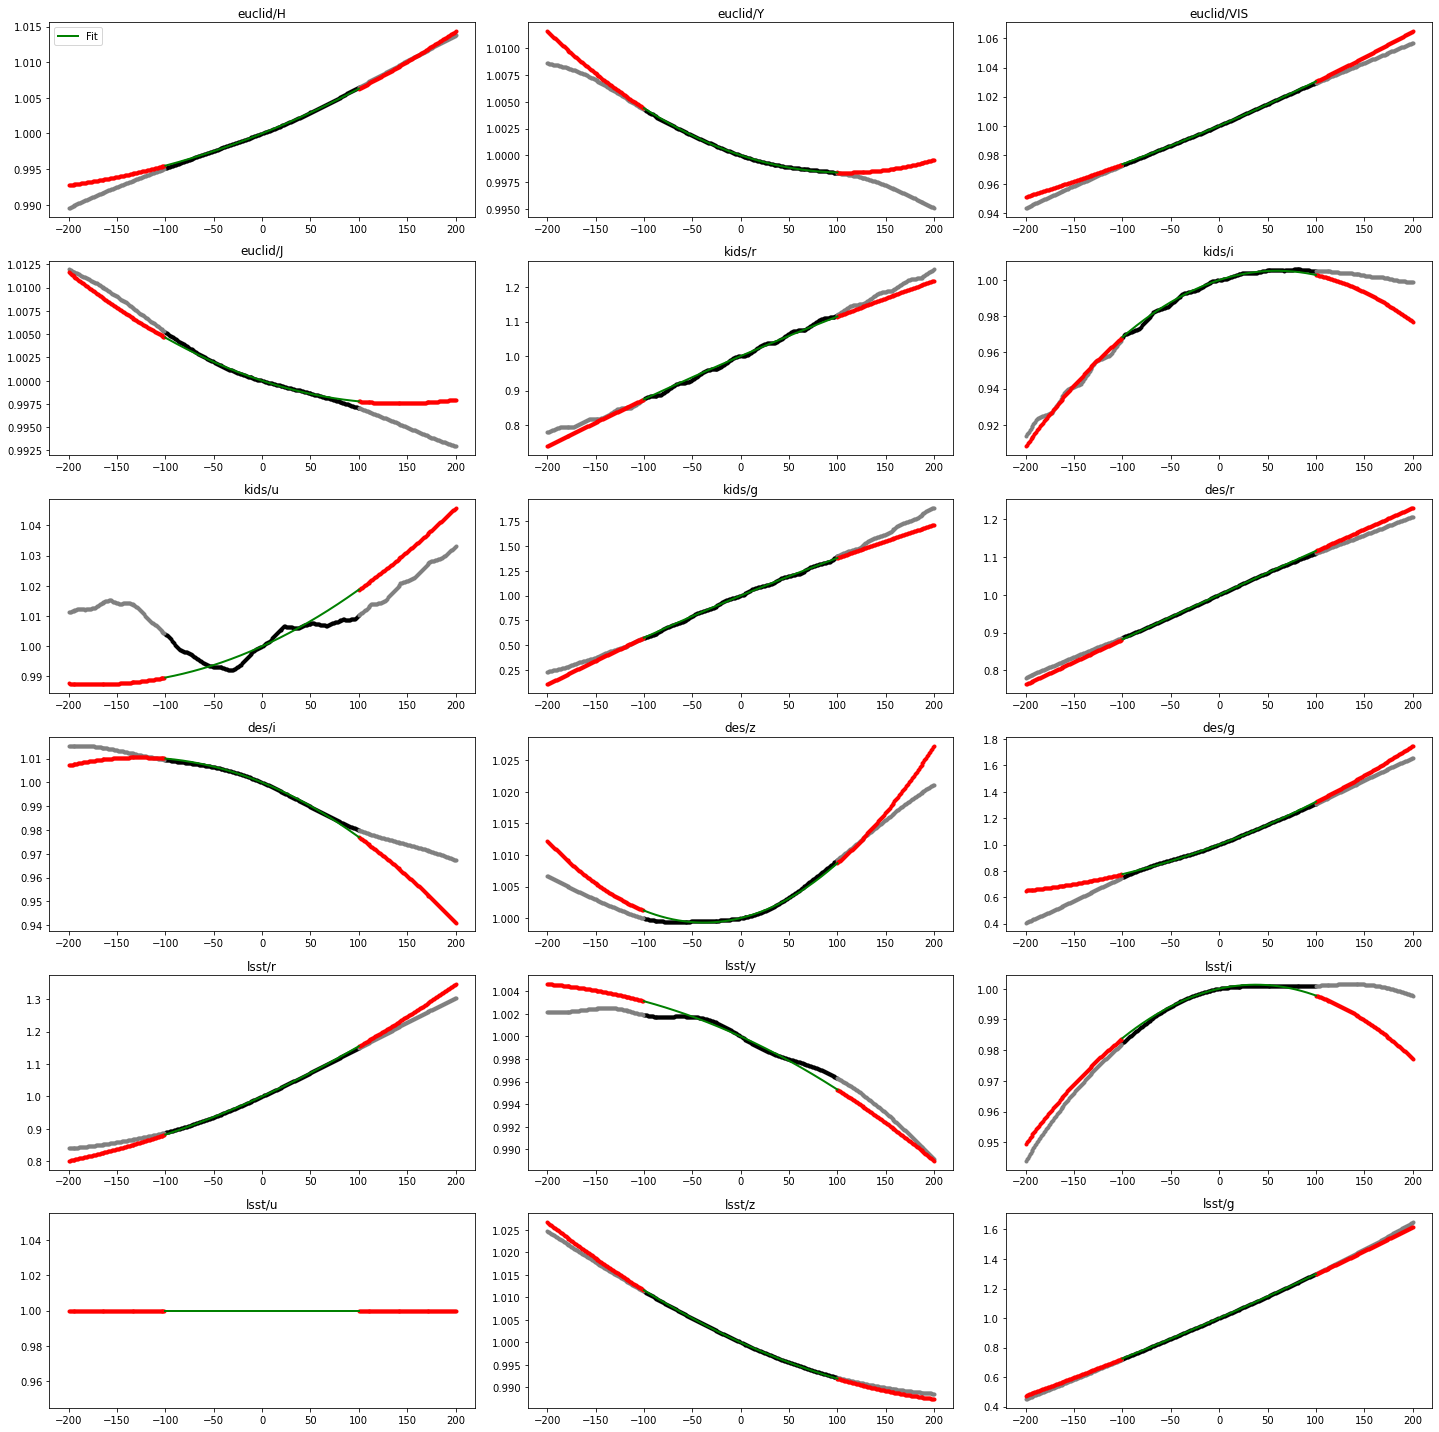

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=len(filter_map)//3, figsize=(20, 20))

for i, ax in enumerate(axes.ravel()):
    fname = filter_names[i]
    
    ax.set_title(fname)
    ax.scatter(shifts, raw[fname] / photo[fname][0], marker='.', color='black')
    ax.scatter(extra_shifts, raw_extra[fname] / photo[fname][0], marker='.', color='gray')
    a, b = corr[filter_names[i]]
    ax.scatter(extra_shifts, a * extra_shifts**2 + b * extra_shifts + 1, color='red', marker='.')
    ax.plot(shifts, a * shifts**2 + b * shifts + 1, color='green', linestyle='-', linewidth=2, label='Fit')
    
    if i == 0:
        ax.legend()
    
plt.tight_layout()